[View in Colaboratory](https://colab.research.google.com/github/narendasan/intro_to_cnns/blob/master/Introduction_to_CNNs_Solutions.ipynb)

# Classifying Handwritting using Convolutional Neural Networks

In this example we are going to use PyTorch, a commonly used Deep Learning Framework to classify Handwritten Digits.

We are going to motivate the use of CNNs by quickly examining Softmax Regression and Multilayer Perceptrons, then use the LeNet5 Network Architecture, an architecture developed by Yann LeCunn in the 1990s to recognize digits on zipcodes.

## Installing Dependencies
PyTorch is a python based framework and does much of the heavy lifting for us when it comes to preprocessing our data and managing the learning process.

We are going to start by installing PyTorch, importing the framework package and the other packages we are going to use


In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install numpy
!pip3 install matplotlib
!pip3 install seaborn

### Loading Helpful Packages
First thing in any app is to include all of the dependencies for the project.



1.   torch (PyTorch) and its specific sub-libraries - This handles all of our neural network setup, training and testing 
2.   torchvision - This is a specific sub-library for PyTorch for computer vision tasks
3.   numpy - Generic matrix library for python
4.   matplotlib and seaborn - graphing libraries for python



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Setting up the Enviorment
We are training our networks on GPUs so we need to make sure to see the random number generator there before we begin

In [0]:
#Enable Cuda
SEED = 1                              #Seed the random wieghts on initialization
LOG_INTERVAL = 100                    #How often to log training and testing info 
torch.cuda.manual_seed(SEED)

## Loading our Data
First thing we are going to do is load our dataset. 

This dataset is called MNIST and it was created by Yann Lecun as a benchmark for handwritting recognition. 
As recognition systems got better, it transitioned to a way to teach people the fundimentals of image classification. The dataset consists of 60,000 training and 10,000 testing 28x28px images from 0-9 in grayscale and their labels. Because it is a common example PyTorch makes it easy to download and setup. 


We want to seperate our training and testing data to prevent what is called **overfitting**. Overfitting is when the model starts to memorize what is in its training set and when that happens it will not be as flexible to new images. So we never want to evaluate the performace of the model on the training data. We use a set of data the network has not seen before to assess how good the network is.


### Dataset Hyper Parameters

Notice there are two "**Hyper Parameters**", numbers that are not optimized by the model but have impact on the performace. There are more hyper parameters below but since we are right now creating our dataset we are going to start with these two: **Batch Size** and **Test Batch Size**. Batch Size defines how many images the model will try to classify before trying to update its weights. Since we are using **Stocastic Gradient Decent** (randomly sampling datapoints from the dataset instead of looking at the set in order), we can get irratic gradient behavior if we update too often with not enough information. A lot of times increasing batch size will improve accuracy of the network and the speed of training (by allowing you to take larger steps), but there is a hard limit on the size of your steps so ever increasing batch size may not be a good idea. The test batch size is less important and only defines how many instances of the model we evaluate at once.



Feel free to tweak these numbers and see how it effects the training and accuracy of your models. Make sure to ```shift + enter``` after setting them to lock the values in


### Data Preprocessing

We dont usually just pass raw images to our model, since we want to reduce the varience in our dataset so distingushing images is an easier task. There are a couple common preprocessing techniques such as subtracting the mean of the dataset from each image and normalizing images. 



![Data Preprocessing - Credit: CS231n Stanford](http://cs231n.github.io/assets/nn2/prepro1.jpeg)




We are going to normalize our data. Luckly pytorch makes this easy, using the transforms lambda functions. I provided the normalization values for you.

In [0]:
#Dataloader
#@title Batch Hyper Parameters
BATCH_SIZE = 64           #@param {type:"integer"}  #Number of training images to process before updating weights
TEST_BATCH_SIZE = 1000    #@param {type:"number"}   #Number of test images to process at once
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader  = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),
                                                     (0.3081,))
                              ])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', 
                   train=False, 
                   transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),
                                                     (0.3081,))
                                ])),
    batch_size=TEST_BATCH_SIZE,
    shuffle=True,
    **kwargs
)

## Creating the Learning Pipeline 

We are going now to layout all the systems to manage training and testing our model

### The Training Pipeline
First we are going to define our **training pipeline**. This is the order of steps in which you go though to train your model on how to complete its task. 
First we start with setting the model to train mode. This allows the parameters in the model to change. This function represents 1 training **epoch**. An epoch is one full interation through the data set. We use the training dataset we created earlier to generate batches of data and their associated true labels. 

For each batch we go through the following steps:

1. Move our data to our GPU
2. Declare our data as Variables in the network
3. Zero all the gradients in the network
3. Run our data through the network and get the predictions
4. Using out chosen loss function, calculate the loss function
5. Calcuate the gradients $\nabla_W$ of the loss with respect to the weights at each node in the network 
5. Update the weights in the network using $W_{t+1} = W_t - \alpha \nabla_W\mathcal L$

In [0]:
def train(model, optimizer, loss_func, epoch, training_history):
    model.train()                                            #Set training mode 
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()            #Transfer data and correct result to the GPU
        data, target = Variable(data), Variable(target)      #Make data and correct answers variables in the Network
        optimizer.zero_grad()                                #zero the gradients
        output = model(data)                                 #classify the data
        loss = loss_func(output, target)                     #calculate the loss
        loss.backward()                                      #propogate the weight updates through the network
        optimizer.step()
        if batch % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch * len(data), len(train_loader.dataset), 100. * batch / len(train_loader), loss.data[0]))
            training_history.append(((len(train_loader.dataset) * epoch) + batch * len(data), loss.data[0]))

### Testing Pipeline
Next we are going to define our **testing or inference pipeline**. During our training we want to intermittently chech the accuracy of our model. Since we don't want to do this with data the model has already seen we will show it new data that it will not remember since we will not be doing backpropogation here. You can see that the pipeline is almost the same with the changes after the data passes through the model and loss is calculated. Here we look at the probablilites outputed by the final layer of the models and find the index of the one with the highest. Each node corressponds to its index's value (e.g. index 0 means 0). We then compare the index of what was predicted to what was expected and calcuated the accuracy.

In [0]:
def test(model, loss_func, epoch, test_loss_history, test_accuracy_history):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()                      #Transfer data and correct result to the GPU
        data, target = Variable(data, volatile=True), Variable(target) #Make data and correct answers variables in the Network
        output = model(data)                                           #classify the data
        test_loss += loss_func(output, target).data[0]                 #calculate loss
        pred = output.data.max(1)[1]                                   #get predictions for the batch using argmax
        correct += pred.eq(target.data).cpu().sum()                    #total correct anwsers 
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_loss_history.append((epoch, test_loss))
    test_accuracy_history.append((epoch, 100. * correct / len(test_loader.dataset)))

This function controls our full training of the model. It takes in a model definition, a selected optimizer and selected loss function and then returns metrics on how the training went and as a byproduct also trains the model. As you can see the learning pipeline iterates according to the number of epochs or the number of times that you want the model to go though the full dataset

In [0]:
def learn(model, optimizer, loss_func):
    training_loss = []
    test_loss = []
    test_accuracy = []
    for e in range(EPOCHS):
        train(model, optimizer, loss_func, e + 1, training_loss)
        test(model, loss_func, e + 1, test_loss, test_accuracy)
    return (training_loss, test_loss, test_accuracy)

### Helpful Utilities
The following function is a function to visualize the learning process, plotting the training loss, testing loss and testing accuracy over time. 

In [0]:
def visualize_learning(training_loss, test_loss, test_accuracy):
    f1 = plt.figure()
    f2 = plt.figure()
    f3 = plt.figure()
    ax1 = f1.add_subplot(111)
    ax2 = f2.add_subplot(111)
    ax3 = f3.add_subplot(111)

    training_loss_batch, training_loss_values = zip(*training_loss)
    ax1.plot(training_loss_batch, training_loss_values)
    ax1.set_title('Training Loss')
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Loss")


    test_loss_epoch, test_loss_values = zip(*test_loss)
    ax2.plot(test_loss_epoch, test_loss_values)
    ax2.set_title("Testing Loss")
    ax2.set_xlabel("Batch")
    ax2.set_ylabel("Loss")

    test_accuracy_epoch, test_accuracy_values = zip(*test_accuracy)
    ax3.plot(test_accuracy_epoch, test_accuracy_values)
    ax3.set_title("Testing Accuracy")
    ax3.set_xlabel("Batch")
    ax3.set_ylabel("Accuracy (%)")

    plt.show()

This function conducts inference on a single image

In [0]:
def classify(model, img):
    img = img.cuda()
    img = Variable(img, volatile=True)
    output = model(img)
    return output.data.max(1)[1]

This function takes an image from the testing set and runs inference on it

In [0]:
def classify_an_example(model):
    img = next(iter(test_loader))[0]
    img_np = img.cpu().numpy()[0]
    plt.imshow(img_np.reshape(28,28))
    print()
    print("The image is probably: {}".format(classify(model, img)[0]))
    print()

## Implementing Sofmax Regression

Our first model of the day is going to be softmax regression. This model can be summed up as simultaneously calculating the probablity that an image is any of the 10 classes at the same time using a set of parameters that represent the importance of particular pixels in the image. 

We use the function $P(y' = \{1..10\}) = \sigma(w^Tx + b)$ where $\sigma = \frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i}}$ to calculate the probablity and we use gradient decent to find the weights. 


### Defining the Model
Pytorch has a super easy way to define machine learning models. We create a sub class of the pytorch class ```torch.nn.Module``` listing out the layers of our model in our ```__init__``` method and the operations between those layers in the method called ```forward```. The ```torch.nn.Module``` super class handles the implementation of the backpropogation.

Go a head and try to fill in what you think a SoftmaxRegression Model would look like.

Here are some useful functions:

- ```torch.nn.Linear``` -> Fully Connected Layer / Impliments $F(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + \boldsymbol b$
- ```torch.nn.Functional.softmax``` -> Softmax function / Implements $F(x) = \frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} }$
- ```torch.nn.Functional.log_softmax``` -> Log of the softmax function / Implements $F(x) = log(\frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} })$
- ```torch.Tensor.view``` -> allows you to reshape a **Tensor** (multi-dimentional vector)

In [0]:
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        return F.softmax(self.fc(x), dim=1)

### Training the Model
Now that we have a model definition, we can train it on our dataset. Below you can see a couple more hyper parameters. 

- **epochs** -> The number of times we show the training dataset to the model 
- **learning rate** -> The size of the step we take each time we go through backpropogation (i.e. the $\alpha$ in $W_{t+1} = W_t - \alpha \nabla_W\mathcal L$)
- **momentum** (_Note: this will only apply if you use SGD_) -> We don't want to get stuck in local minima in the loss landscape so we may want to not let a particularly bad batch prevent otherwise good progress. We can redefine the parameter update procedure as $W_{t+1} = W_t - \alpha V_t$ and $V_t = \beta V_{t-1} + (1 - \beta)\nabla_W\mathcal L$ where $\beta$
is our notion of momentum

Set these values to something you think might be reasonable and see what happens. Make sure to ```shift+enter``` to lock them in.

In [0]:
#@title Training Hyper Parameters
EPOCHS = 10                #@param {type:"integer"}           #Number of times to go through the data set
LEARNING_RATE = 0.001     #@param {type:"number"}            #How far each update pushes the weights
SGD_MOMENTUM = 0.5        #@param {type:"number"}            #How much it takes to change the direction of the gradient


Now we can create an instance of our model and transfer it to the GPU (using the ```nn.Module.cuda``` method).

Now chose your optimizer, there are a bunch of choices (the most common one is **Stocastic Gradient Decent**, but others include ADAM, ADA and more). Take a look at http://pytorch.org/docs/master/optim.html#algorithms for a list of choices, but if you need a recomendation use ```torch.optim.SGD```

Next we need to pick a **loss** function. This function calcaluates how far off our prediction was from the expected value. Again there are a whole bunch of options. Here is a list http://pytorch.org/docs/master/nn.html#id46
If you are not sure what to choose then use ```torch.nn.functional.nll_loss``` which is negative log likelihood loss ($L(y) = -log(y)$) a common function to use with softmax



In [20]:
sr_model = SoftmaxRegression()
sr_model.cuda()
sr_optimizer = optim.SGD(sr_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(sr_model)
SR_TRAINING_LOSS, SR_TEST_LOSS, SR_TEST_ACCURACY = learn(sr_model, sr_optimizer, F.nll_loss) #negative loss values may be due to your final layer

SoftmaxRegression(
  (fc): Linear(in_features=784, out_features=10)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: -0.086829
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.100926
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.128526
Train Epoch: 1 [19200/60000 (32%)]	Loss: -0.175426
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.224740
Train Epoch: 1 [32000/60000 (53%)]	Loss: -0.264054
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.394530
Train Epoch: 1 [44800/60000 (75%)]	Loss: -0.339074
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.411560
Train Epoch: 1 [57600/60000 (96%)]	Loss: -0.433010

Test set: Average loss: -0.4495, Accuracy: 5488/10000 (55%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.394009
Train Epoch: 2 [6400/60000 (11%)]	Loss: -0.402880
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.506822
Train Epoch: 2 [19200/60000 (32%)]	Loss: -0.503808
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.453076
Train Epoch: 2 [32000/60000 (53%)]	Loss: -0.421061
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.488321
Train Epoch: 

Train Epoch: 6 [32000/60000 (53%)]	Loss: -0.843142
Train Epoch: 6 [38400/60000 (64%)]	Loss: -0.734277
Train Epoch: 6 [44800/60000 (75%)]	Loss: -0.809047
Train Epoch: 6 [51200/60000 (85%)]	Loss: -0.714007
Train Epoch: 6 [57600/60000 (96%)]	Loss: -0.827553

Test set: Average loss: -0.8091, Accuracy: 8820/10000 (88%)

Train Epoch: 7 [0/60000 (0%)]	Loss: -0.843280
Train Epoch: 7 [6400/60000 (11%)]	Loss: -0.787827
Train Epoch: 7 [12800/60000 (21%)]	Loss: -0.810713
Train Epoch: 7 [19200/60000 (32%)]	Loss: -0.856809
Train Epoch: 7 [25600/60000 (43%)]	Loss: -0.793119
Train Epoch: 7 [32000/60000 (53%)]	Loss: -0.808486
Train Epoch: 7 [38400/60000 (64%)]	Loss: -0.757858
Train Epoch: 7 [44800/60000 (75%)]	Loss: -0.791215
Train Epoch: 7 [51200/60000 (85%)]	Loss: -0.798329
Train Epoch: 7 [57600/60000 (96%)]	Loss: -0.786131

Test set: Average loss: -0.8206, Accuracy: 8842/10000 (88%)

Train Epoch: 8 [0/60000 (0%)]	Loss: -0.855235
Train Epoch: 8 [6400/60000 (11%)]	Loss: -0.750542
Train Epoch: 8 [12800

### Visualizing How Well the Training Went

Now we should have a reasonably well trained model. Lets see how the train went. Use the visualization function to plot the **training loss**, **testing loss** and **testing accuracy** over the course of the training. 

_Notice: We do not measure the training accuracy, since it is not a good measure of how good the model is since we are looking for a model that has good performace **on data not yet seen**_

We should see the training loss quickly decline then plateau. 
  - If you are seeing jagged training loss perhaps increase the batch size or decrease the learning rate 
  
You should see that the testing loss more gradually reduces 
  - if you see the testing loss starting to go up, you are now overfitting - probably reduce the number of epochs

You should also see the testing accuracy increase at the same rate the testing loss decreases

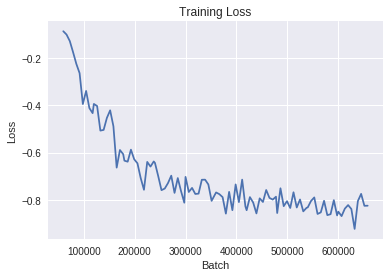

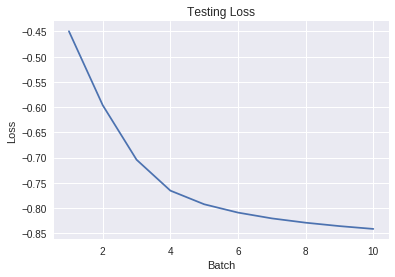

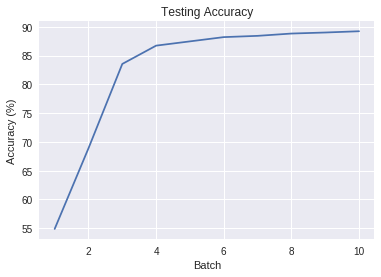

In [21]:
visualize_learning(SR_TRAINING_LOSS, SR_TEST_LOSS, SR_TEST_ACCURACY)

### Trying an Example on Your Trained Model

Use the ```classify_an_example``` helper function to classify an example from the testing set


The image is probably: 2



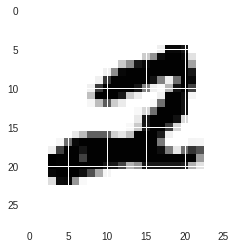

In [22]:
classify_an_example(sr_model)

## Implementing Multilayer Perceptron

Next we are going to implement a mulilayer perceptron. Each layer weights the importance of the data from the previous layer, eventually terminating in the same sigmoid function to convert the representation vector of the input data into a probablity. Between each layer we now include a **non-linearity or activation function**, a function that allows the model to approximate non linear functions and filter data between layers.

Each layer of the MLP now looks like this $relu(w^Tx +b)$ and the full model becomes $\sigma(w^T relu(w^T relu(w^Tx + b)+ b) + b)$

Again we train this model with gradient decent

### Defining the Model
Once again we are going to create a sub class of the pytorch class ```torch.nn.Module``` listing out the layers of our model in our ```__init__``` method and the operations between those layers in the method called ```forward```. The ```torch.nn.Module``` super class handles the implementation of the backpropogation.

Go a head and try to fill in what you think a Multilayer Perceptron Model would look like.

Here are some useful functions:

- ```torch.nn.Linear``` -> Fully Connected Layer / Impliments $F(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + \boldsymbol b$
- ```torch.nn.Functional.relu``` -> Rectifying Linear Unit / Implements $max(0,x)$ 
    - Other activation functions can be found here: http://pytorch.org/docs/master/nn.html#non-linear-activation-functions 
- ```torch.nn.Functional.softmax``` -> Softmax function / Implements $F(x) = \frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} }$
- ```torch.nn.Functional.log_softmax``` -> Log of the softmax function / Implements $F(x) = log(\frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} })$
- ```torch.Tensor.view``` -> allows you to reshape a **Tensor** (multi-dimentional vector)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.log_softmax(x, dim=1)

### Training the Model
Again we are going to set our training hyper parameters

- **epochs** -> The number of times we show the training dataset to the model 
- **learning rate** -> The size of the step we take each time we go through backpropogation (i.e. the $\alpha$ in $W_{t+1} = W_t - \alpha \nabla_W\mathcal L$)
- **momentum** (_Note: this will only apply if you use SGD_) -> We don't want to get stuck in local minima in the loss landscape so we may want to not let a particularly bad batch prevent otherwise good progress. We can redefine the parameter update procedure as $W_{t+1} = W_t - \alpha V_t$ and $V_t = \beta V_{t-1} + (1 - \beta)\nabla_W\mathcal L$ where $\beta$
is our notion of momentum

Set these values to something you think might be reasonable and see what happens. Make sure to ```shift+enter``` to lock them in.

In [0]:
#@title Training Hyper Parameters
EPOCHS = 15                #@param {type:"integer"}           #Number of times to go through the data set
SGD_MOMENTUM = 0.5        #@param {type:"number"}            #How much it takes to change the direction of the gradient
LEARNING_RATE = 0.001     #@param {type:"number"}            #How far each update pushes the weights


Again create an instance of your model and transfer it to the GPU (using the ```nn.Module.cuda``` method).

Now chose your optimizer. Take a look at http://pytorch.org/docs/master/optim.html#algorithms for a list of choices, but if you need a recomendation use ```torch.optim.SGD```

Next we need to pick a **loss** function.  Here is a list http://pytorch.org/docs/master/nn.html#id46
If you are not sure what to choose then use ```torch.nn.functional.nll_loss``` which is negative log likelihood loss ($L(y) = -log(y)$) a common function to use with softmax

In [29]:
mlp_model = MLP()
mlp_model.cuda()
mlp_optimizer = optim.SGD(mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(mlp_model)
MLP_TRAINING_LOSS, MLP_TEST_LOSS, MLP_TEST_ACCURACY = learn(mlp_model, mlp_optimizer, F.nll_loss)

MLP(
  (fc1): Linear(in_features=784, out_features=500)
  (fc2): Linear(in_features=500, out_features=500)
  (fc3): Linear(in_features=500, out_features=500)
  (fc4): Linear(in_features=500, out_features=10)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302263
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.289508
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.277936
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.283029
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.264199
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.263595
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.260824
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.200495
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.187876
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.205881

Test set: Average loss: 2.1789, Accuracy: 4316/10000 (43%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.209007
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.092618
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.095743
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.037634
Train Epoch: 2 [25600/60000 (43%)]	Loss: 

Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.528755
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.481870
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.726936
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.656589
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.744564
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.515434
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.544851

Test set: Average loss: 0.5829, Accuracy: 8176/10000 (82%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.570525
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.355285
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.527012
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.733478
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.599054
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.750621
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.396912
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.509894
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.554203
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.531132

Test set: Average loss: 0.5508, Accuracy: 8248/10000 (82%)

Train Epoch: 8 [0/60000 (0%)]	Loss


Test set: Average loss: 0.4834, Accuracy: 8397/10000 (84%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.302725
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.451118
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.432946
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.675001
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.277164
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.727703
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.336181
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.623527
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.296063
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.584374

Test set: Average loss: 0.4725, Accuracy: 8432/10000 (84%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.399461
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.554551
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.623883
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.532850
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.365323
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.613584
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.503229
Train Epoch: 13 [44800/

### Visualizing How Well the Training Went

Now we should have a reasonably well trained model. Lets see how the train went. Use the visualization function to plot the **training loss**, **testing loss** and **testing accuracy** over the course of the training. 

_Notice: We do not measure the training accuracy, since it is not a good measure of how good the model is since we are looking for a model that has good performace **on data not yet seen**_

We should see the training loss quickly decline then plateau. 
  - If you are seeing jagged training loss perhaps increase the batch size or decrease the learning rate 
  
You should see that the testing loss more gradually reduces 
  - if you see the testing loss starting to go up, you are now overfitting - probably reduce the number of epochs

You should also see the testing accuracy increase at the same rate the testing loss decreases

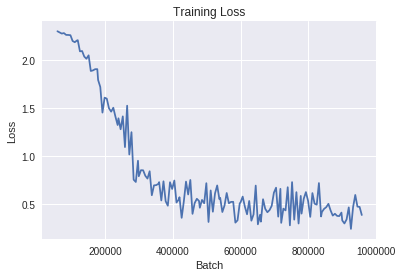

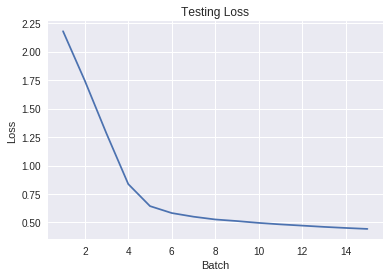

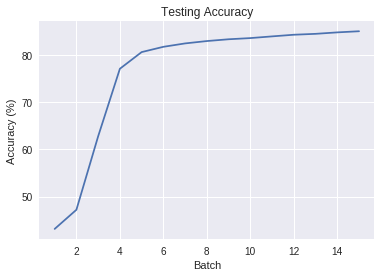

In [30]:
visualize_learning(MLP_TRAINING_LOSS, MLP_TEST_LOSS, MLP_TEST_ACCURACY)

### Trying an Example on Your Trained Model

Use the ```classify_an_example``` helper function to classify an example from the testing set


The image is probably: 6



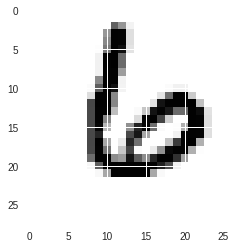

In [31]:
classify_an_example(mlp_model)

## Implementing LeNet

Our final model of the day is going to be LeNet (LeCun 1998). LeNet uses convolution layers to learn usuful features in the image instead of relying on just pixels. Then by stacking more convolution layers on top the model begins to extra useful collections of features. This terminates in a MLP which tries to associate this high level representation of the image with the label. 

Now our model looks like this $\sigma(w^T relu(w^T relu(w^T relu(w * relu( w * x + b) + b)+ b)+ b) + b)$ and again we can train this with gradient decent

### Defining the Model
Once again we are going to create a sub class of the pytorch class ```torch.nn.Module``` listing out the layers of our model in our ```__init__``` method and the operations between those layers in the method called ```forward```. The ```torch.nn.Module``` super class handles the implementation of the backpropogation.

Go a head and try to fill in what you think a Multilayer Perceptron Model would look like.

Here are some useful functions:

- ```torch.nn.Conv2d``` -> 2 Dimentional Convolution / Implements $F(\boldsymbol ) = \boldsymbol b + \sum_{k=0}^{C_{in} - 1} \boldsymbol w * \boldsymbol x$
- ```torch.nn.Linear``` -> Fully Connected Layer / Impliments $F(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + \boldsymbol b$
- ```torch.nn.Functional.relu``` -> Rectifying Linear Unit / Implements $max(0,x)$ 
    - Other activation functions can be found here: http://pytorch.org/docs/master/nn.html#non-linear-activation-functions 
- ```torch.nn.Functional.softmax``` -> Softmax function / Implements $F(x) = \frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} }$
- ```torch.nn.Functional.log_softmax``` -> Log of the softmax function / Implements $F(x) = log(\frac{e^{ \boldsymbol x}} {\sum_\limits{i \in dim \boldsymbol x} e^{\boldsymbol x_i} })$
- ```torch.Tensor.view``` -> allows you to reshape a **Tensor** (multi-dimentional vector)
- ```torch.nn.Dropout2d``` -> randomly set a percentage of weights to randomly be set to 0 each update to prevent overfitting


In [0]:
#Network
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training the Model
Again we are going to set our training hyper parameters

- **epochs** -> The number of times we show the training dataset to the model 
- **learning rate** -> The size of the step we take each time we go through backpropogation (i.e. the $\alpha$ in $W_{t+1} = W_t - \alpha \nabla_W\mathcal L$)
- **momentum** (_Note: this will only apply if you use SGD_) -> We don't want to get stuck in local minima in the loss landscape so we may want to not let a particularly bad batch prevent otherwise good progress. We can redefine the parameter update procedure as $W_{t+1} = W_t - \alpha V_t$ and $V_t = \beta V_{t-1} + (1 - \beta)\nabla_W\mathcal L$ where $\beta$
is our notion of momentum

Set these values to something you think might be reasonable and see what happens. Make sure to ```shift+enter``` to lock them in.

In [0]:
#@title Training Hyper Parameters
EPOCHS = 5                #@param {type:"integer"}           #Number of times to go through the data set
SGD_MOMENTUM = 0.5        #@param {type:"number"}            #How much it takes to change the direction of the gradient
LEARNING_RATE = 0.001     #@param {type:"number"}            #How far each update pushes the weights


Again create an instance of your model and transfer it to the GPU (using the ```nn.Module.cuda``` method).

Now chose your optimizer. Take a look at http://pytorch.org/docs/master/optim.html#algorithms for a list of choices, but if you need a recomendation use ```torch.optim.SGD```

Next we need to pick a **loss** function.  Here is a list http://pytorch.org/docs/master/nn.html#id46
If you are not sure what to choose then use ```torch.nn.functional.nll_loss``` which is negative log likelihood loss ($L(y) = -log(y)$) a common function to use with softmax

In [35]:
cnn_model = LeNet()
cnn_model.cuda()
cnn_model_optimizer = optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(cnn_model)
CNN_TRAINING_LOSS, CNN_TEST_LOSS, CNN_TEST_ACCURACY = learn(cnn_model, cnn_model_optimizer, F.nll_loss)

LeNet(
  (conv1): Conv2d (1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2)
  (fc1): Linear(in_features=800, out_features=500)
  (fc2): Linear(in_features=500, out_features=10)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285554
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.155993
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.012254
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.668985
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.211285
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.888964
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.730533
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.572084
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.516982
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.381755

Test set: Average loss: 0.3979, Accuracy: 8903/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.411250
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.485648
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.304532
Train Epoch: 2 [19200/60000 (32%)]	

### Visualizing How Well the Training Went

Now we should have a reasonably well trained model. Lets see how the train went. Use the visualization function to plot the **training loss**, **testing loss** and **testing accuracy** over the course of the training. 

_Notice: We do not measure the training accuracy, since it is not a good measure of how good the model is since we are looking for a model that has good performace **on data not yet seen**_

We should see the training loss quickly decline then plateau. 
  - If you are seeing jagged training loss perhaps increase the batch size or decrease the learning rate 
  
You should see that the testing loss more gradually reduces 
  - if you see the testing loss starting to go up, you are now overfitting - probably reduce the number of epochs

You should also see the testing accuracy increase at the same rate the testing loss decreases

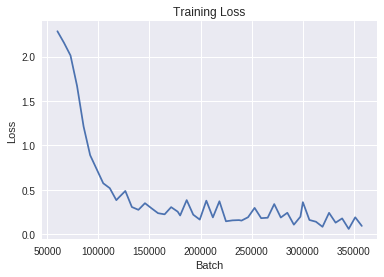

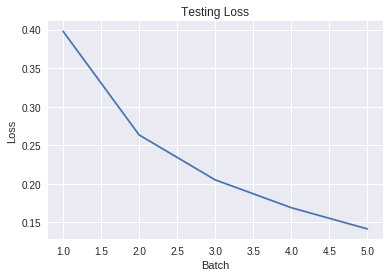

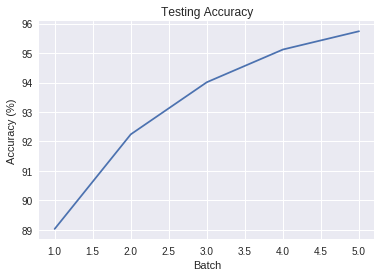

In [36]:
visualize_learning(CNN_TRAINING_LOSS, CNN_TEST_LOSS, CNN_TEST_ACCURACY)

### Trying an Example on Your Trained Model

Use the ```classify_an_example``` helper function to classify an example from the testing set


The image is probably: 3



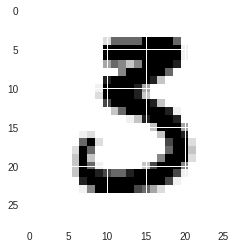

In [37]:
classify_an_example(cnn_model)

## Congratulations!

You just trained 3 different machine learning models and all of them are relatively good at detecting handwritting. There is a big world of models, tasks and strategies to explore. But one more thing before we finish this tutorial...

### Limits of your model

You trained a model, it gets something like 98% accuracy on your testing dataset. But is it ready to go out into the world and classify digits?

Lets take a look at an example again... 


The image is probably: 4



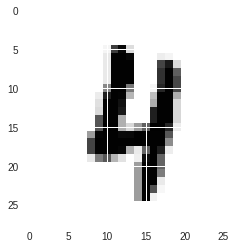

In [38]:
classify_an_example(cnn_model)

But what if I give you this image? 

It is supposed to be a 4


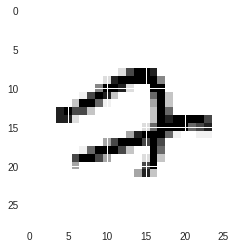

In [41]:
img, label = next(iter(test_loader))
img = img[0][0]
label = label[0]
img_transpose = img.transpose(0,1)
img_view = img_transpose.cpu().numpy()
plt.imshow(img_view.reshape(28,28))
print("It is supposed to be a " + str(label))

In [42]:
print("The model thinks it is a " + str(classify(cnn_model, img_transpose.unsqueeze(0).unsqueeze(0))[0]))

The model thinks it is a 7


What could we do to solve this problem?

This is the main job of ML engineers...